In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def plot_confusion_matrix(cm, classes,
normalize=False,
title='Confusion matrix',
cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", round(precision,2))
    print("Recall: ", round(recall,2))
    print("F-score: ", round(Fscore,2))
    print("Accuracy: ", round(accuracy,2))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
url = '/content/drive/MyDrive/AIDatasets/Detecting-Depression-in-Tweets-master/sentiment_tweets3.csv'
df = pd.read_csv(url)

In [6]:
df['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

##Cleaning


In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
corpus = []
for i in range(0,10314):
    tweet = df['message'][i]
    tweet = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', ' ', tweet) # remove urls
    tweet = re.sub(r'#', '', tweet) # remove hashtag symbol
    tweet = re.sub(r'<([^>]*)>', ' ', tweet) # remove emojis
    tweet = re.sub('[^a-zA-Z]',' ', tweet) 
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

In [9]:
# Creating dataframe of cleaned data
df = pd.DataFrame({'message':corpus, 'label':df['label']})
df.head(),df.tail()

(                                             message  label
 0                 real good moment missssssssss much      0
 1                                         read manga      0
 2                                       comeagainjen      0
 3  lapcat need send em account tomorrow oddli eve...      0
 4                    add myspac myspac com lookthund      0,
                                                  message  label
 10309      depress g herbo mood done stress peopl deserv      1
 10310  depress succumb brain make feel like never enough      1
 10311  ketamin nasal spray show promis depress suicid...      1
 10312             dont mistak bad day depress everyon em      1
 10313                                                         1)

In [10]:
batch_1 = df.sample(n=2000)

In [11]:
batch_1['label'].value_counts()

0    1548
1     452
Name: label, dtype: int64

In [12]:
# b2 = df.sample(n=2000)
# b2['label'].value_counts()

In [13]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## For BERT
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
tokenized = batch_1['message'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [15]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [16]:
np.array(padded).shape

(2000, 66)

In [17]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 66)

In [18]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [19]:
features = last_hidden_states[0][:,0,:].numpy()

In [20]:
labels = batch_1['label']

In [21]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [22]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(train_features, train_labels)

In [23]:
# lr_clf.score(test_features, test_labels)
y_pred = lr_clf.predict(test_features)

In [24]:
from sklearn.metrics import confusion_matrix
cm_bert = confusion_matrix(test_labels, y_pred)

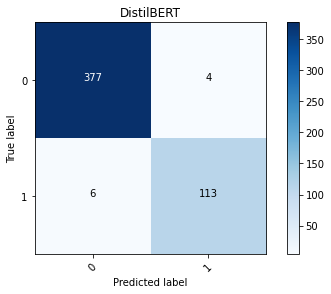

In [25]:
plot_confusion_matrix(cm_bert,[0,1],title='DistilBERT')

In [26]:
metrics(list(test_labels),list(y_pred))

Precision:  0.97
Recall:  0.95
F-score:  0.96
Accuracy:  0.98
